# 用户画像

## 什么是用户画像

1. Persona是真实用户的虚拟代表，是建立在一系列真实数据之上的目标用户模型。
2. 根据用户的目标、行为和观点的差异，将他们区分为不同的类型，每种类型中抽取出典型特征，形成了一类人物原型
3. 简单理解：用户信息标签化

## 为什么需要用户画像

精准营销、推荐、获客，等等

## 怎么建立用户画像

- 要贴标签，先有数据，一般将用户数据划分为静态信息数据、动态信息数据，两大类。
- 静态数据：用户相对稳定的信息，如：性别、地域、职业、消费等级……
- 动态数据：用户不停变化的行为信息，如：浏览网页、搜索商品、评论……
- 找到最合适的数据，建立模型

举例：

- 一台相机
- 一台胶片相机
- 一台胶片单反相机
- 一台尼康胶片单反相机
- 一台尼康FM2胶片单反相机

## 用户画像的应用

1. 电商平台、推荐系统
2. 根据用户需求，生产、销售商品

# 用户画像-案例


### 基于用户搜索关键词数据为用户打上标签（年龄，性别，学历）

## 整体流程

<img src="./img/1.png" alt="FAO" width="500" align="right">

### （一）数据预处理
* 编码方式转换
* 对数据搜索内容进行分词
* 词性过滤
* 数据检查

### （二）特征选择
* 建立word2vec词向量模型
* 对所有搜索数据求平均向量

### （三）建模预测
* 不同机器学习模型对比
* 堆叠模型

### 将原始数据转换成utf-8编码，防止后续出现各种编码问题
由于原始数据比较大，在分词与过滤阶段会比较慢，这里我们选择了原始数据中的1W个

In [2]:
import csv
import pandas as pd
import jieba.analyse
import time
import jieba
import jieba.posseg
import os, sys
import datetime
from gensim.models import Word2Vec
import gensim
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [7]:

# 原始数据存储路径
data_path = './data/user_tag_query.10W.TRAIN' 
# 生成数据路径
csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'age', 'Gender', 'Education', 'QueryList'])
# 转换成utf-8编码的格式
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            line.strip()          
            data = line.split("\t")
            # 取出前4列
            writedata = [data[0], data[1], data[2], data[3]]
            querystr = ''
            data[-1]=data[-1][:-1]
            # 文字部分，单独进行转换
            for d in data[4:]:
                try:
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'
                except:
                    continue
                    print (data[0][0:10])
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            print (data[0][0:20])
            continue

88493167693C2776346A
46D475B97C1B305FFFDA
D28EC7418BF4CDF5239A
16093E4F1ACF59E959A5
D2051528049CBF1DE199
10C1674D16E1BB3B7511
F6DA152A5441E7713A14
CA3613A5C3B312420601
3654893CF3E2BAB04B65
7CAB36D0FA392BCE37FB
6EA7152B5401E7B54C50
E501B22C6C5875C4EA5D


测试集的编码转换方式同上

In [8]:
data_path = './data/user_tag_query.10W.TEST'
csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'QueryList'])
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            data = line.split("\t")
            writedata = [data[0]]
            querystr = ''
            data[-1]=data[-1][:-1]
            for d in data[1:]:
                try:                  
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'               
                except:
                    print (data[0][0:10])
                    continue
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            print (data[0][0:20])
            continue

4CD5040896BA356E72DA
E00AEC15047083F804A3
501F4E8C14D5DF1864AE
F2041F03DD27AD2ED79F
75AFBDE421CCE1196E7D
9BEE20D0AB66E18CC924
E84177F10EE30EBCF042
AE44EC3BBD90AAD01B23
3A0486A73AAC1389B8DF
7F07EA81781637569953
8F002DFB390A2661C688
E7C3F52EE9232FBFF7F1
3905D7ED72A7AC813763
92909F83C4E7AD86EDBE
DB042E860BBA1E26E91F
C3FD77FBF2B29998D713
649FE10B5E867A884516
7D5C08345447950A6291
D192E3C2893CF045DAF7
9B3A3ED49EC9B214A764
7B23B2A45E46B05BB577


### 生成对应的数据表

In [9]:
# 编码转换完成的数据，取的是1W的子集
trainname = './data/user_tag_query.10W.TRAIN-1w.csv'
testname = './data/user_tag_query.10W.TEST-1w.csv'

data = pd.read_csv(trainname,encoding='gbk')
print (data.info())

# 分别生成三种标签数据（性别，年龄，学历）
data.age.to_csv("./data/train_age.csv", index=False)
data.Gender.to_csv("./data/train_gender.csv", index=False)
data.Education.to_csv("./data/train_education.csv", index=False)
# 将搜索数据单独拿出来
data.QueryList.to_csv("./data/train_querylist.csv", index=False)

data = pd.read_csv(testname,encoding='gbk')
print (data.info())

data.QueryList.to_csv("./data/test_querylist.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         9988 non-null   object
 1   age        9988 non-null   int64 
 2   Gender     9988 non-null   int64 
 3   Education  9988 non-null   int64 
 4   QueryList  9988 non-null   object
dtypes: int64(3), object(2)
memory usage: 390.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9978 entries, 0 to 9977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         9978 non-null   object
 1   QueryList  9978 non-null   object
dtypes: object(2)
memory usage: 156.0+ KB
None


### 对用户的搜索数据进行分词与词性过滤
这里需要分别对训练集和测试集进行相同的操作，路径名字要改动一下

In [10]:
# 读取训练集
def input(trainname):
    traindata = []
    with open(trainname, 'rb') as f:
        line = f.readline()
        count = 0
        while line:
            try:
                traindata.append(line)
                count += 1
            except:
                print ("error:", line, count)
            line=f.readline()
    return traindata
start = time.process_time()

filepath = './data/test_querylist.csv'
QueryList = input(filepath)

writepath = './data/test_querylist_writefile-1w.csv'
csvfile = open(writepath, 'w')

POS = {}
for i in range(len(QueryList)):
    # 显示已经完成的结果，2000条以上
    if i%2000 == 0 and i >=1000:
        print (i,'finished') 
    s = []
    str = ""
    # 带有词性的精确分词模式jieba.posseg.cut
    words = jieba.posseg.cut(QueryList[i])
    allowPOS = ['n','v','j']
    for word, flag in words:
        POS[flag]=POS.get(flag,0)+1
        if (flag[0] in allowPOS) and len(word)>=2:
            str += word + " "
            
    cur_str = str.encode('utf8')
    cur_str = cur_str.decode('utf8')
    s.append(cur_str)
    # 把分词，再连起来
    csvfile.write(" ".join(s)+'\n')
csvfile.close()

end = time.process_time()
print ("total time: %f s" % (end - start))
print(datetime.timedelta(seconds=(end - start)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jarod\AppData\Local\Temp\jieba.cache
Loading model cost 0.498 seconds.
Prefix dict has been built successfully.


2000 finished
4000 finished
6000 finished
8000 finished
total time: 428.593750 s
0:07:08.593750


### 使用Gensim库建立word2vec词向量模型
### 参数定义：
-  sentences：可以是一个list
-  sg： 用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
-  size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
-  window：表示当前词与预测词在一个句子中的最大距离是多少
-  alpha: 是学习速率
-  seed：用于随机数发生器。与初始化词向量有关。
-  min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
-  max_vocab_size: 设置词向量构建期间的RAM限制。如果所有独立单词个数超过这个，则就消除掉其中最不频繁的一个。每一千万个单词需要大约1GB的RAM。设置成None则没有限制。

-  workers参数控制训练的并行数。
-  hs: 如果为1则会采用hierarchica·softmax技巧。如果设置为0（defau·t），则negative sampling会被使用。
-  negative: 如果>0,则会采用negativesamp·ing，用于设置多少个noise words
-  iter： 迭代次数，默认为5

In [3]:

begin_time = time.time()
# 将数据变换成list of list格式
train_path = './data/train_querylist_writefile-1w.csv'
with open(train_path, 'r') as f:
    My_list = []
    lines = f.readlines()
    for line in lines:
        cur_list = []
        line = line.strip()
        data = line.split(" ")
        for d in data:
            cur_list.append(d)
        My_list.append(cur_list)
    
    model = Word2Vec(My_list, size=300, window=10,workers=4)  
    savepath = '1w_word2vec_' + '300'+'.model' # 保存model的路径

    model.save(savepath)
    
end_time = time.time()
print(datetime.timedelta(seconds=(end_time - begin_time)))

0:00:36.483104


In [4]:
begin_time = time.time()
similart1 = model.wv.most_similar("大哥")
end_time = time.time()
print(datetime.timedelta(seconds=(end_time - begin_time)))
print(similart1)

0:00:00.108335
[('桃色', 0.9065385460853577), ('卢嘉丽', 0.9019551277160645), ('刘希平', 0.8955543041229248), ('宋冬野', 0.894570529460907), ('卧底', 0.891724169254303), ('许文强', 0.8900036811828613), ('蛮族', 0.8898410797119141), ('乞丐', 0.8872543573379517), ('卡普', 0.8868241310119629), ('陈宝莲', 0.885728120803833)]


In [13]:
begin_time = time.time()
similart2 = model.wv.most_similar("清华")
end_time = time.time()
print(datetime.timedelta(seconds=(end_time - begin_time)))
print(similart2)

0:00:00.004003
[('中国人民大学', 0.9295936822891235), ('复旦大学', 0.9242755174636841), ('清华大学', 0.9213669896125793), ('高级中学', 0.9168827533721924), ('特长生', 0.911332368850708), ('北京大学', 0.9054535627365112), ('工作部', 0.9036219120025635), ('专题报告', 0.9021010398864746), ('南开大学', 0.896014928817749), ('报道', 0.8957517147064209)]


### 加载训练好的word2vec模型，求用户搜索结果的平均向量

In [14]:

file_name = './data/train_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        # 求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

<ipython-input-14-b9bd3c448cac>:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in cur_model:
<ipython-input-14-b9bd3c448cac>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vec += np.array([cur_model[word]])


In [15]:
doc_cev.shape

(9988, 300)

In [16]:
doc_cev[5]

array([-2.79721386e-01, -5.88722366e-02, -3.19634924e-01, -3.21698704e-01,
       -5.04635896e-02,  2.25936315e-01, -2.78876511e-01,  1.56714355e-02,
        1.56537017e-01,  2.09135118e-01,  1.43723864e-01, -1.33955074e-01,
       -1.32927727e-01,  5.34089923e-03, -2.89463446e-01,  1.67750407e-01,
       -6.61430349e-01, -5.00182637e-02,  4.77711579e-01, -1.29794130e-02,
       -3.52161000e-01,  1.12261925e-01,  8.76122027e-02,  3.24142125e-01,
        2.37824574e-01,  2.59117366e-02, -1.67820506e-01, -1.18966530e-01,
        3.25827460e-01,  6.37985393e-01, -2.81235228e-03, -3.05435646e-01,
       -1.06124188e-02,  2.61348602e-02,  1.21263121e-02, -2.33696655e-01,
       -2.51350443e-01,  1.37140740e-01, -7.31197575e-02, -3.00564336e-01,
        3.19229969e-01, -6.59228686e-02, -1.51449168e-01,  1.98551224e-01,
       -2.75223350e-01, -7.24948769e-02, -2.92432854e-01, -2.82359476e-01,
        2.29237064e-01,  1.74732879e-01,  1.00080986e-01, -1.36934879e-01,
       -6.79174655e-02,  

In [24]:
genderlabel = np.loadtxt(open('./data/train_gender.csv', 'r'), skiprows=1)
# train_gender = './data/train_gender.csv'
# genderlabel = pd.read_csv(train_gender)
genderlabel.shape

(9988,)

In [25]:
educationlabel = np.loadtxt(open('./data/train_education.csv', 'r'), skiprows=1)
# train_education = './data/train_education.csv'
# educationlabel = pd.read_csv(train_education)
educationlabel.shape

(9988,)

In [26]:
agelabel = np.loadtxt(open('./data/train_age.csv', 'r'), skiprows=1)
# train_age = './data/train_age.csv'
# agelabel = pd.read_csv(train_age)
agelabel.shape

(9988,)

In [27]:
# 处理0的数据
def removezero(x, y):
        nozero = np.nonzero(y)
        y = y[nozero]
        x = np.array(x)
        x = x[nozero]
        return x, y
gender_train, genderlabel = removezero(doc_cev, genderlabel)
age_train, agelabel = removezero(doc_cev, agelabel)
education_train, educationlabel = removezero(doc_cev, educationlabel)
print (gender_train.shape,genderlabel.shape)
print (age_train.shape,agelabel.shape)
print (education_train.shape,educationlabel.shape)

(9756, 300) (9756,)
(9815, 300) (9815,)
(9064, 300) (9064,)


### 绘图函数，以性别为例，绘制混淆矩阵

In [28]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 测试集的构造方法和训练集一样

In [31]:

file_name = './data/test_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

<ipython-input-31-ea373c71f44a>:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in cur_model:
<ipython-input-31-ea373c71f44a>:16: RuntimeWarning: invalid value encountered in true_divide
  doc_cev[cur_index] = word_vec / float(wrod_num)
<ipython-input-31-ea373c71f44a>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vec += np.array([cur_model[word]])


### 检查一下数据有木有问题

In [32]:
doc_cev.shape

(9979, 300)

In [33]:
doc_cev[6]

array([ 4.64003542e-02,  1.54896722e-01, -1.79494302e-02, -7.06838603e-02,
       -2.23018234e-01,  1.88339798e-01, -4.28976566e-01, -5.47362816e-02,
       -1.16062785e-01, -2.43434461e-01, -1.66564816e-02,  1.14870393e-01,
        3.19601222e-01, -4.21473928e-01, -2.30567018e-01,  2.15982951e-01,
        1.17248221e-01, -2.67648162e-02, -1.17768898e-01,  4.32744112e-02,
        3.36601103e-01, -1.39781379e-01,  2.09998444e-01, -1.15836076e-01,
        1.38919647e-01,  2.02625918e-01, -4.93102518e-02,  8.12740528e-02,
       -2.55069441e-01, -2.43508028e-01, -5.41170472e-02,  1.56733764e-01,
       -6.85639093e-02,  3.09888568e-01, -6.24813488e-02,  5.61527372e-02,
       -4.84165873e-01,  2.14772335e-01, -1.78254137e-01,  3.17285577e-01,
        7.52217524e-02,  4.92674430e-02,  8.02950502e-02, -1.22456875e-01,
        6.57419908e-02, -1.62455342e-01, -1.50754149e-01,  3.35617056e-01,
        1.88697600e-01, -6.07865293e-02,  6.88584475e-03,  7.38739078e-03,
       -1.15868973e-01,  

### 建立一个基础预测模型

0.8017418032786885
Recall metric in the testing dataset:  0.7412935323383084
accuracy metric in the testing dataset:  0.8017418032786885


C:\Users\jarod\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


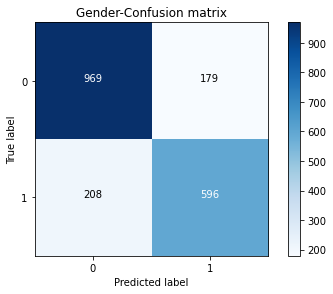

In [35]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

LR_model = LogisticRegression()

LR_model.fit(X_train,y_train)
y_pred = LR_model.predict(X_test)
print (LR_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

0.798155737704918
Recall metric in the testing dataset:  0.7350746268656716
accuracy metric in the testing dataset:  0.798155737704918


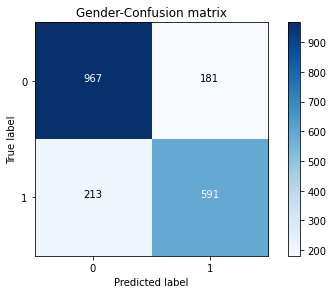

In [37]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

RF_model = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)

RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
print (RF_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()